# Example Usage

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np

from pathlib import Path
from scipy import stats

# Import library
from nems_fingerprint import *
from nems_fingerprint.euler_bernoulli_beam import displacement as ebb_disp

# Plotting
import bokeh
import bokeh.palettes as palettes

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.layouts import Column, gridplot

palette = palettes.Category10[10]

output_notebook()

Loading BokehJS ...

In [3]:
%%html
<!-- So that markdown cells don't stretch across the whole screen -->
<style>
.jp-RenderedMarkdown {
    max-width: 700px;
}
.jp-MarkdownCell {
    max-width: 900px;
}
</style>

In [4]:
# Generic plot settings

line_settings = dict(
    line_width=2,
    muted_alpha=0.1
)

fig_settings = dict(
    width=500,
    height=350
)

tool_settings = dict(
    toolbar_location=None,
    tools=[]
)

## Euler-Bernoulli Beam Simulation

In [5]:
ebb_sim = EBBSimulation(
    boundary_type='clamped-free',
    mode_indices=[1, 2, 3],
    mass_dist=Distribution.constant(1.0),
        position_dist=Distribution.uniform(0.0, 1.0),
    noise_dist=Distribution.normal(0.0, 0.02)
)

# Using Original Implementation
learning_events = ebb_sim.sample(n_events=1000)
mass_predictor_0 = MassPredictNN(learning_events)

measurement_phase_shifts = ebb_sim.sample(n_events=2000).freq_shifts
masses_0 = mass_predictor_0(measurement_phase_shifts)

In [6]:
# Abstract KD-Tree
mass_predictor_1 = NNPredictor(learning_events)
masses_1 = mass_predictor_1(measurement_phase_shifts)

# Abstract SKLearn
mass_predictor_2 = NNPredictor(learning_events)
masses_2 = mass_predictor_2(measurement_phase_shifts)

In [7]:
print(np.array_equal(masses_0, masses_1), np.array_equal(masses_1, masses_2))

True True


In [8]:
masses = masses_0
hist, bin_edges = np.histogram(np.log(masses), density=True, bins=200, range=(-1, 1))
masses_sorted = np.sort(masses)
freq_shifts = learning_events.freq_shifts

settings = dict(margin=20)

p1 = figure(
    x_axis_label='$$\Delta f_1 / f_1$$',
    y_axis_label='$$\Delta f_2 / f_2$$',
    **settings
)
p1.scatter(freq_shifts[:, 0], freq_shifts[:, 1])

p2 = figure(
    x_axis_label='$$\Delta f_1 / f_1$$',
    y_axis_label='$$\Delta f_3 / f_3$$',
    **settings
)
p2.scatter(freq_shifts[:, 0], freq_shifts[:, 2])


p3 = figure(
    x_axis_label='sample # / N',
    y_axis_label='mass',
    y_axis_type='log',
    **settings
)
p3.scatter(np.arange(len(masses)) / len(masses), masses_sorted)


p4 = figure(
    x_axis_label='log(Mass)',
    y_axis_label='pdf',
    **settings
)
p4.quad(top=hist, bottom=0, left=bin_edges[:-1], right=bin_edges[1:])



for p in (p1, p2):
    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"

ps = [p1, p2, p3, p4]
gs = gridplot(ps, ncols=2, width=400, height=400)
show(gs)

In [24]:
# Build Sensiblity model from learned events
sens_model = chi2Sensiblity(learning_events)

# Calculate sensibility of actual events
sensible_measurements = sens_model(measurement_phase_shifts)

model_trained


In [25]:
# Generate "nonsensible" measurments by gathering points randomly sampling space
random_vectors = np.random.uniform(low=-1.0, high=1.0, size=measurement_phase_shifts.shape)
# Calculate sensibility of random events
nonsensible_measurements = sens_model(random_vectors)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Histogram of Boolean Values')

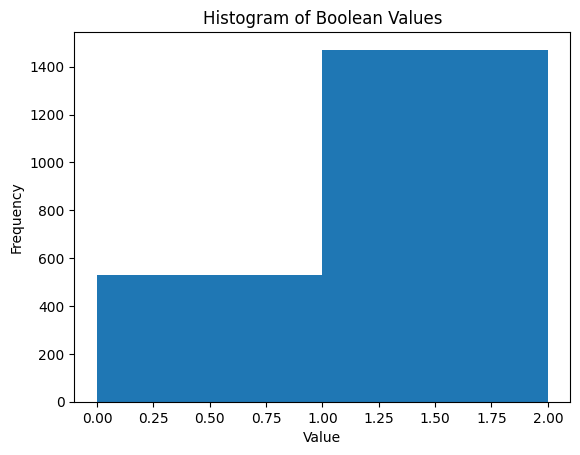

In [27]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(sensible_measurements, bins=[0, 1, 2], align='mid')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Boolean Values')

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Histogram of Boolean Values')

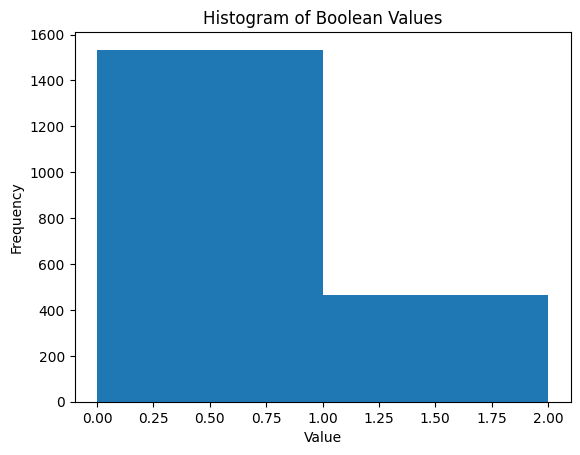

In [26]:
# Create the histogram
plt.hist(nonsensible_measurements, bins=[0, 1, 2], align='mid')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Boolean Values')

In [ ]:
sens_model.cov